In [1]:
import or_suite
import numpy as np
import gym

CONFIG = or_suite.envs.env_configs.vaccine_4groups_default_config

/Users/mayleencortez/Desktop/Spring 2021/ORSuite/or_suite/envs/ambulance
/Users/mayleencortez/Desktop/Spring 2021/ORSuite/or_suite/envs


In [2]:
# making an instance of the environment
env = gym.make('Vaccine-v0', config=CONFIG)

In [3]:
print(env.state)
print(env.action_space)
print(env.observation_space)

[ 990 1990  990 5990   10   10   10   10    0    0    0]
Discrete(25)
MultiDiscrete([10001 10001 10001 10001 10001 10001 10001 10001 10001 10001 10001])


In [4]:
# testing the step function
newState, reward,  done, info = env.step(0)
print(newState)
print(reward)
print(done)

[ 838 1522  900 4931   51  221    9  450  107   58 1144]
-1144.0
False


In [5]:
newState, reward,  done, info = env.step(0)
print(newState)
print(reward)
print(done)

[ 335  132  609 1676  262  814   57 1629  445  220 4814]
-4814.0
False


In [6]:
newState, reward,  done, info = env.step(0)
print(newState)
print(reward)
print(done)

[  69    0  261  483  184  328   48  952  257  168 1314]
-1314.0
False


In [7]:
newState, reward,  done, info = env.step(0)
print(newState)
print(reward)
print(done)

[  4   0  16  23  80 136  17 366 101  82 145]
-145.0
True


# Vaccine Allotment Code Demonstration

Reinforcement learning (RL) is a natural model for problems involving real-time sequential decision making. In these models, a principal interacts with a system having stochastic transitions and rewards and aims to control the system online (by exploring available actions using real-time feedback) or offline (by exploiting known properties of the system).

This project revolves around providing a unified landscape on scaling reinforcement learning algorithms to operations research domains.

In this notebook we walk through generating plots, and applying the problem to the `vaccine allotment` problem with a population of size $P$ split into four risk classes, a discrete state space $\mathcal{S} = \{0, 1, 2, \ldots, P\}^{11}$, and a discrete action space consisting of "priority orders" corresponding to how we allot vaccines to the four risk classes. In this case, a valid priority order is one of two options: 
1. an empty list -- interpreted as no priority order, meaning we vaccinate the population randomly
2. a permutation of the numbers $\{1,2,3,4\}$ -- interpreted as the order in which we vaccinate the risk classes

### Step 1: Import Required Packages

The main package for ORSuite is contained in `or_suite`.  However, some additional packages may be required for specific environments / algorithms.  Here, we include `stable baselines`, a package containing implementation for state of the art deep RL algorithms, and `matploblib` for the plotting.

In [8]:
import or_suite
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import numpy as np

### Step 2: Pick problem parameters for the environment

Here we use the ambulance metric environment as outlined in `or_suite/envs/ambulance/ambulance_metric.py`.  The package has default specifications for all of the environments in the file `or_suite/envs/env_configs.py`, and so we use one the default for the ambulance problem in a metric space.

In addition, we need to specify the number of episodes for learning, and the number of iterations (in order to plot average results with confidence intervals).

In [9]:
DEFAULT_CONFIG = or_suite.envs.env_configs.vaccine_4groups_default_config
epLen = DEFAULT_CONFIG['epLen']
nEps = 200
numIters = 5

### Step 3: Pick simulation parameters

Next we need to specify parameters for the simulation.  This includes setting a seed, the frequency to record the metrics, directory path for saving the data files, a deBug mode which prints the trajectory, etc.

In [10]:
DEFAULT_SETTINGS = {'seed': 1, 
                    'recFreq': 1, 
                    'dirPath': '../data/vaccine/', 
                    'deBug': False, 
                    'nEps': nEps, 
                    'numIters': numIters,
                    'render': False,
                    'saveTrajectory': True, 
                    'epLen' : 5}

vaccine_env = gym.make('Vaccine-v0', config=DEFAULT_CONFIG)
mon_env = Monitor(vaccine_env)

### Step 4: Pick list of algorithms

We have several heuristics implemented for each of the environments defined, in addition to a `random` policy, and some `RL discretization based` algorithms.  Here we pick a couple of the heuristics, and a PPO algorithm implemented from `stable baselines` just to test.

In [11]:
agents = {'Random': or_suite.agents.rl.random.randomAgent(),
          'SB PPO': PPO(MlpPolicy, mon_env, gamma=1, verbose=0, n_steps=epLen),
          }

/Users/mayleencortez/anaconda3/lib/python3.7/site-packages/stable_baselines3/ppo/ppo.py:132: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 4`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a multiple of `n_steps * n_envs`.
Info: (n_steps=4 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


### Step 5: Run simulations

In [12]:
#or_suite.utils.run_single_algo(mon_env, agents['Random'], DEFAULT_SETTINGS)

In [13]:
for agent in agents:
    print(agent)
    DEFAULT_SETTINGS['dirPath'] = '../data/vaccine_metric_test_'+str(agent)+'/'
    if agent == 'SB PPO':
        or_suite.utils.run_single_sb_algo(mon_env, agents[agent], DEFAULT_SETTINGS)
    else:
        or_suite.utils.run_single_algo(mon_env, agents[agent], DEFAULT_SETTINGS)

Random
**************************************************
Running experiment
**************************************************
**************************************************
Experiment complete
**************************************************
**************************************************
Saving data
**************************************************
Writing to file data.csv
**************************************************
Data save complete
**************************************************
SB PPO
**************************************************
Running experiment
**************************************************


ValueError: arrays must all be same length

### Step 6: Generate figures

In [15]:
path_list_line = []
path_list_radar = []
algo_list_line = []
algo_list_radar = []

print(str(agents['Random']))
path_list_line.append('../data/vaccine_metric_test_'+str(agents['Random'])+'/data.csv')
algo_list_line.append(str(agents['Random']))
path_list_radar.append('../data/vaccine_metric_test_'+str(agents['Random'])+'/')
algo_list_radar.append(str(agents['Random']))

FileNotFoundError: [Errno 2] No such file or directory: '../data/vaccine_metric_test_<or_suite.agents.rl.random.randomAgent object at 0x1293fc240>/data.csv/data.csv'

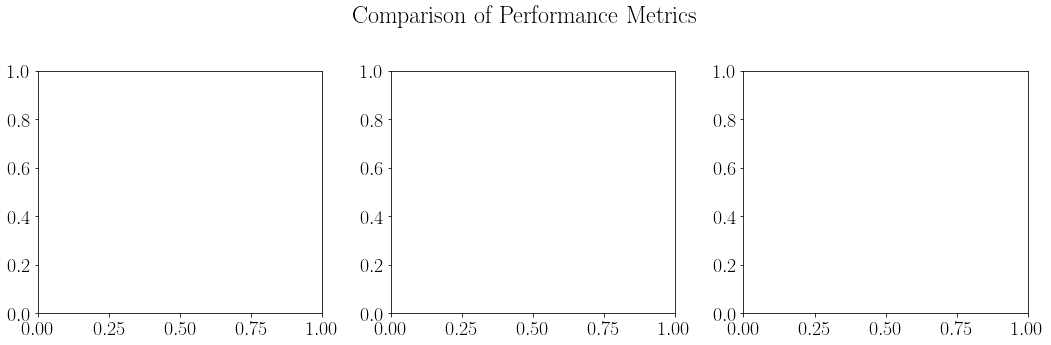

In [16]:
fig_path = '../figures/'
fig_name = 'test_vaccine_metric.pdf'

or_suite.plots.plot_line_plots(path_list_line, algo_list_line, fig_path, fig_name, int(nEps / 40) + 1)

#additional_metric = {'MRT': lambda traj : or_suite.utils.mean_response_time(traj, lambda x, y : np.abs(x-y))}

or_suite.plots.plot_radar_plots(path_list_radar, algo_list_radar, fig_path, fig_name)

In [ ]:
path_list_line = []
path_list_radar = []
algo_list_line = []
algo_list_radar = []

for agent in agents:
    print(str(agent))
    path_list_line.append('../data/vaccine_metric_test_'+str(agent)+'/data.csv')
    algo_list_line.append(str(agent))
    if agent != 'SB PPO':    
        path_list_radar.append('../data/vaccine_metric_test_'+str(agent)+'/')
        algo_list_radar.append(str(agent))

    

fig_path = '../figures/'
fig_name = 'test_vaccine_metric.pdf'

or_suite.plots.plot_line_plots(path_list_line, algo_list_line, fig_path, fig_name, int(nEps / 40) + 1)

additional_metric = {'MRT': lambda traj : or_suite.utils.mean_response_time(traj, lambda x, y : np.abs(x-y))}


or_suite.plots.plot_radar_plots(path_list_radar, algo_list_radar, fig_path, fig_name, additional_metric)

In [ ]:
from stable_baselines3.common.env_checker import check_env

In [ ]:
check_env(vaccine_env, skip_render_check=True)